In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scienceplots # `pip install scienceplots` or `conda install -c conda-forge scienceplots` through terminal
plt.style.use(["science", "notebook", "grid"])

rcparams = {"axes.linewidth" : 0.5,
           "lines.linewidth" : 1.0,
           "font.family" : "serif",
           "font.size" : 22,
           "legend.fontsize" : 16,
           "legend.loc" : "upper right",
           "mathtext.fontset" : "stix",
           "text.usetex" : True}
mpl.rcParams.update(rcparams)

import torch
import torch.nn as nn
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.set_default_dtype(torch.float32)

# PINN Networks

Physics - Informed Neural Networks or PINNs incorporate known physical laws or constraints into the training process of neural networks. This method allows for more accurate predictions when the available data is limited. A method that is usually approached is regularization, which is applied in order to avoid overfitting. Essentially, since the data is not adequate for training, a simpler resulting answer is sought. The formula for regularizing the loss function is given by,

$${Loss}_{reg}=\frac{1}{N}\Sigma_{i}^{N}\left(f(x_{i}|\vec{\theta})-y_{i} \right)^{2}+\lambda||\vec{\theta}||_{2}^{2},$$

where $(x_{i}, y_{i})$ is some data and $f(x_{i}|\vec{\theta})$ is a neural network with a set of parameters $\vec{\theta}$ that approximates $y$. 

Assuming that the problem being solved is a differential equation $g(x, y)=0$, the loss function takes the form,

$${Loss}_{PINN}= \frac{1}{N}\Sigma_{j}^{N}||f(x_{j}|\vec{\theta})-y_{j} ||_{2}^{2}+\lambda\frac{1}{M}\Sigma_{i}^{M}||g(x_{i},f(x_{i}|\vec{\theta}))||_{2}^{2},$$

where $(x_{j},y_{j})$ are data points, while $x_{i}$ are **collocation** points that are **hyperparametrized**. The constant $\lambda$ is another **hyperparameter** (`loss2_weight`). The first term of the right hand side is called the **data loss**, while the last term is called the **physics loss**.

The data points can be either experimental data or, in the case of an ODE or PDE, a combination of initial conditions (IVPs) and boundary values (BVPs). 

## Solving ODEs using PINNs

This part is based on: https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a

The corresponding code can be found in modular form here: https://github.com/TheodoreWolf/pinns/tree/main/src/cooling

I tried to write it in one notebook, because it is more convenient for learning purposes.

In [2]:
# Essential functions

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def np_to_th(x):
    # Turn numpy data to torch tensor.
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).reshape(n_samples, -1).detach().to(DEVICE)

def cooling_law(time, Tenv, T0, R):
    # Analytical solution to the cooling equation.
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

In [3]:
# Create a model class.

class Net(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 n_units=100,
                 epochs=1000,
                 loss=nn.MSELoss(),
                 lr=1e-3,
                 loss2=None,
                 loss2_weight=0.1,
    ) -> None:
        # Inherit from superclass nn.Module
        super().__init__()
        
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
    
    def forward(self, x):
        return self.out(self.layers(x))
    
    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)
        
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in tqdm(range(self.epochs)):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs/10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
            
        return losses
    
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()

In [4]:
# Create a NetDiscovery class (subclass of Net that parametrizes r). 
# Will be used later on to retrieve the value of r from the data instead of presetting it.

class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

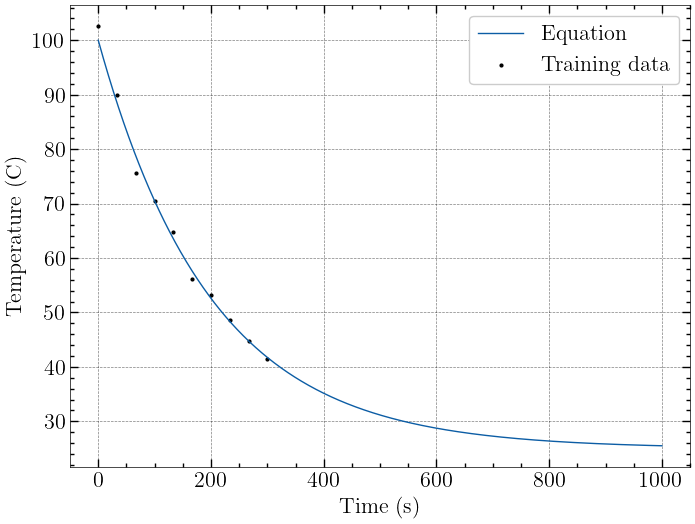

In [5]:
# Initialize some parameters.

np.random.seed(10)
Tenv = 25
T0 = 100
R = 5e-3
times = np.linspace(0, 1000, 1000)
#eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R) # Create cooling_law(t).
def eq(t): return cooling_law(t, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Create training data.
t = np.linspace(0, 300, 10)
T = eq(t) + 2 * np.random.randn(10)
plt.plot(times, temps)
plt.scatter(t, T, s=4, color="black")
plt.legend(["Equation", "Training data"])
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")
plt.show()

### Vanilla Networks

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.71
Epoch 4000/20000, loss: 2153.85
Epoch 6000/20000, loss: 761.03
Epoch 8000/20000, loss: 97.47
Epoch 10000/20000, loss: 2.51
Epoch 12000/20000, loss: 0.48
Epoch 14000/20000, loss: 0.39
Epoch 16000/20000, loss: 0.37
Epoch 18000/20000, loss: 0.35


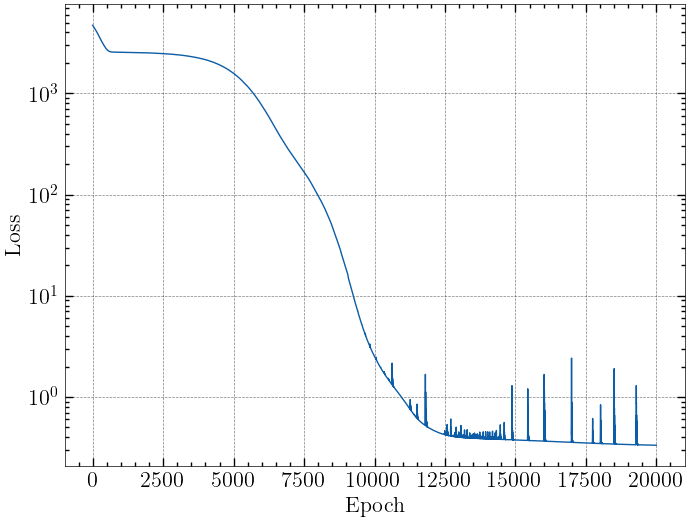

In [6]:
# Fit without regularisation.
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 0/20000, loss: 11219.99
Epoch 2000/20000, loss: 3938.91
Epoch 4000/20000, loss: 2417.21
Epoch 6000/20000, loss: 1597.58
Epoch 8000/20000, loss: 1183.66
Epoch 10000/20000, loss: 987.13
Epoch 12000/20000, loss: 902.67
Epoch 14000/20000, loss: 831.77
Epoch 16000/20000, loss: 767.23
Epoch 18000/20000, loss: 706.50


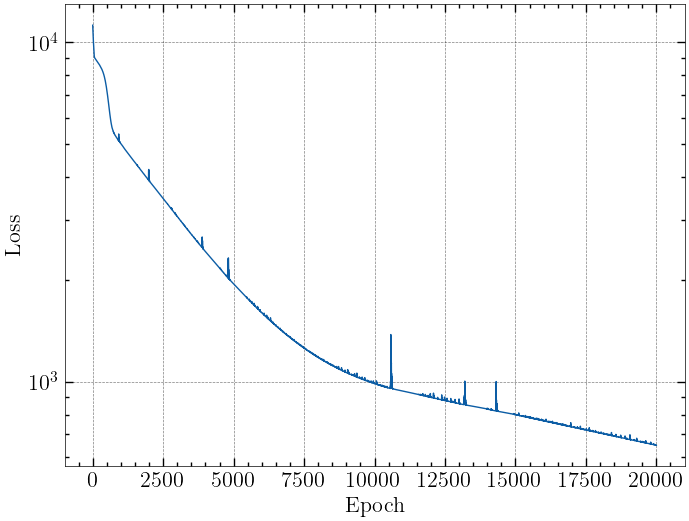

In [7]:
# Loss regularization.
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

# Create an instance of the net class that takes loss regularization into account.
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Text(0.5, 0, 'Time (s)')

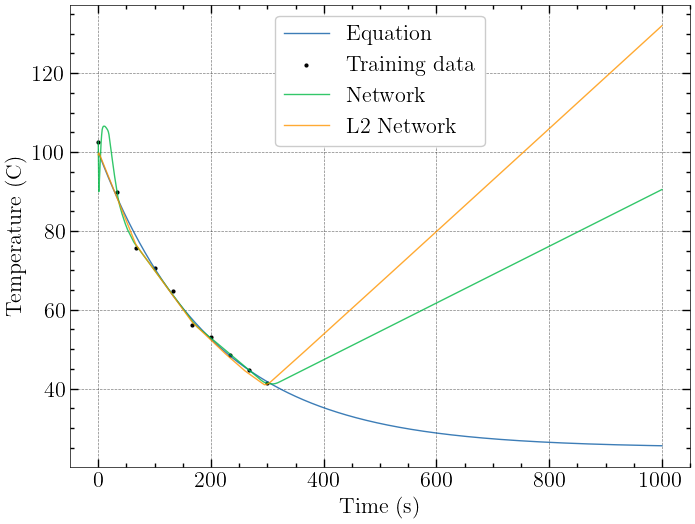

In [8]:
# Predictions based on initial model that doesn't apply loss regularization.
preds = net.predict(times)
# Predictions based on final model that applies loss regularization.
predsreg = netreg.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.scatter(t, T, s=4, color="black")
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=["Equation", "Training data", "Network", "L2 Network"], loc="best")
plt.ylabel("Temperature (C)")
plt.xlabel("Time (s)")

In [9]:
# Define physics loss function based on the ODE.
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0/30000, loss: 4775.84
Epoch 3000/30000, loss: 2435.33
Epoch 6000/30000, loss: 538.34
Epoch 9000/30000, loss: 0.88
Epoch 12000/30000, loss: 0.38
Epoch 15000/30000, loss: 0.36
Epoch 18000/30000, loss: 0.35
Epoch 21000/30000, loss: 0.34
Epoch 24000/30000, loss: 0.33
Epoch 27000/30000, loss: 0.41


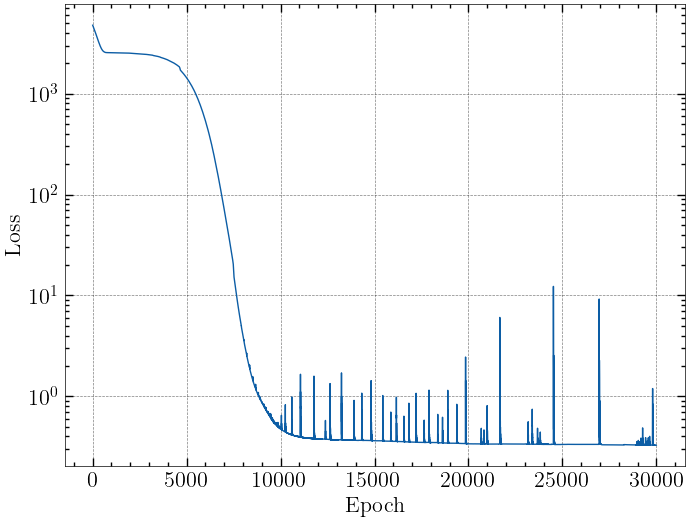

In [10]:
# Fitting of the model that applies loss regularization based on the physics loss function.
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Text(0.5, 0, 'Time (s)')

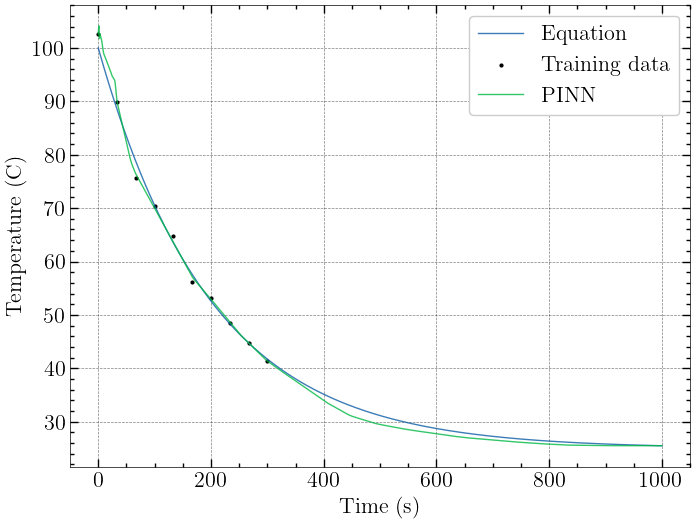

In [11]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.scatter(t, T, color="black", s=4)
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

### Parameter Discovery

Subsequently, the neural network is adapted so as to predict the value of the cooling rate $r$ as well. Essentially, another parameter is added to the network (`class NetDiscovery(Net)`).

In [12]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

  0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2501.38
Epoch 8000/40000, loss: 2076.19
Epoch 12000/40000, loss: 560.10
Epoch 16000/40000, loss: 4.04
Epoch 20000/40000, loss: 1.48
Epoch 24000/40000, loss: 1.06
Epoch 28000/40000, loss: 0.60
Epoch 32000/40000, loss: 0.38
Epoch 36000/40000, loss: 0.30


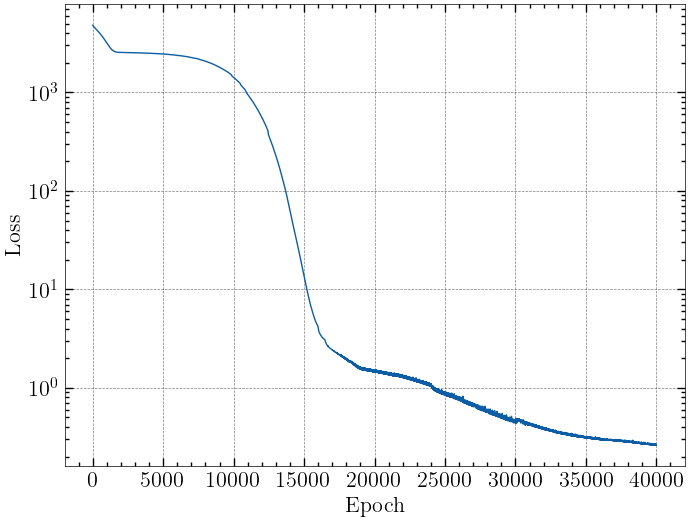

In [13]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Text(0.5, 0, 'Time (s)')

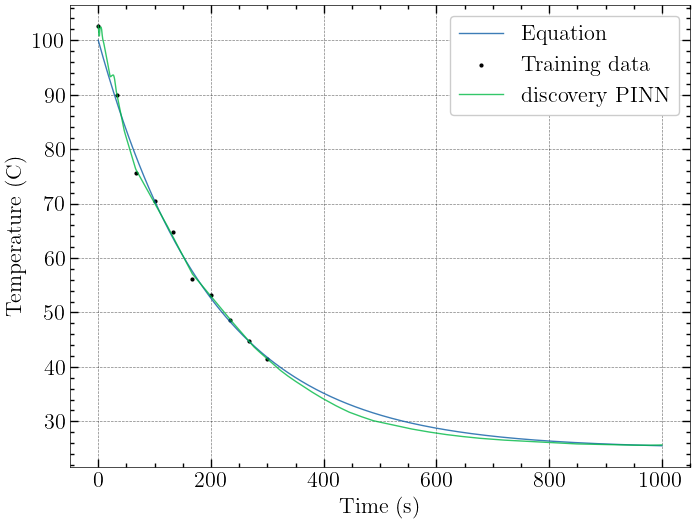

In [14]:
preds = netdisc.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.scatter(t, T, color="black", s=4)
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [15]:
# Estimated value of r.
netdisc.state_dict()["r"]
# or print(netdisc.r)

tensor([0.0052])

In [16]:
# Save model
torch.save(netdisc.state_dict(), "netdisc.pth")

## Solving systems of ODEs using PINNs.

The Lotka - Volterra equations is a system of two ODEs,

$$\frac{dx}{dt}=\alpha x-\beta xy,$$

$$\frac{dy}{dt}=\delta xy -\gamma y,$$

where $\alpha$, $\beta$, $\gamma$, $\delta$ are constants.

The following code will focus on solving this system for $\alpha=1$, $\beta=1$, $\gamma=1$, $\delta=1$, alongside the initial conditions,

$$x(t=0)=1.5$$

$$y(t=0)=1.0$$ 

### PINN solution.

The following model will give two outputs, one for the values of $x$ and one for the values of $y$. The implementation of the code below differs from the previous example mainly in that it has two output layers. In order for the output of the model to represent the values of $x$ and $y$, shape manipulation has to occur. While reading the code, pay close attention to the reshaping.  

It should be noted that the solutions are highly sensitive to the choice of hyperparameters. In general, if the ODE or PDE being solved showcases gradient instabilty (basically, if the derivatives of the outputs change abruptly) the learning rate chosen should be neither too small nor too large. In addition, the activation function that is chosen should match the behaviour of both the ICs/BVs and the analytical solution. This ensures that the loss decreases rapidly and, most importantly, that the result truly represents the desired solution. A wrong choice of the activation function can lead to a perfectly running model that adequately minimizes the loss, yet yields incorrect results.

The choice of the Lotka - Volterra equations was inspired from the equivalent solution presented in the README file of the `neurodiffeq` library, which is listed at the _further reading_ section at the end of this notebook. The example in the README file calculates the solution using the modules of the library, while the code below manually builds the corresponding neural network.  

In [17]:
# Create a custom sinusoid activation function.
class SinActivation(nn.Module):
    def forward(self, input):
        return torch.sin(input)

# Create a model class.

class Net_V2(nn.Module):
    def __init__(self,
                 input_dim=1,
                 output_dim=2,
                 n_units=100,
                 epochs=1000,
                 loss=nn.MSELoss(),
                 lr=1e-3,
                 loss2=None,
                 loss2_weight=0.1,
    ) -> None:
        # Inherit from superclass nn.Module
        super().__init__()
        
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            SinActivation(),
            nn.Linear(self.n_units, self.n_units),
            SinActivation(),
            nn.Linear(self.n_units, self.n_units),
            SinActivation(),
            nn.Linear(self.n_units, self.n_units),
            SinActivation(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
    
    def forward(self, t):
        out = self.out(self.layers(t))
        out = out.permute(*torch.arange(out.ndim - 1, -1, -1)) # Initial shape is [1000, 2]. The transpose gives a shape [2, 1000].
        return out[0].unsqueeze(dim=1), out[1].unsqueeze(dim=1) # Turn shapes [1000] to [1000, 1] so that the loss function can properly compare the input and target data.
    
    def fit(self, T, x, y):
        Tt = np_to_th(T)
        xt = np_to_th(x)
        yt = np_to_th(y)
        
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in tqdm(range(self.epochs)):
            optimiser.zero_grad()
            x_out, y_out = self.forward(Tt)
            loss = self.loss(xt, x_out) + self.loss(yt, y_out)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs/10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
            
        return losses
    
    def predict(self, T):
        self.eval()
        x_pred, y_pred = self.forward(np_to_th(T))
        return x_pred.squeeze().detach().cpu().numpy(), y_pred.squeeze().detach().cpu().numpy()

In [18]:
# Initial Conditions.
t0 = np.array([0]) ; x0 = np.array([1.5]) ; y0 = np.array([1.0])

# \vec{f}(t, x, y) = 0
def f(t, model: torch.nn.Module):
    x, y = model(t)
    x_t = grad(x, t)[0]
    y_t = grad(y, t)[0]
    ode1 = x_t - x + x*y
    ode2 = y_t - x*y + y
    return ode1, ode2

def physics_loss(model: torch.nn.Module, loss=nn.MSELoss()):
    t_col = torch.linspace(0, 12, steps=500,).view(-1,1).requires_grad_(True).to(DEVICE)
    zeros = torch.zeros_like(t_col).float().view(-1,1).requires_grad_(False).to(DEVICE)
    ode1, ode2 = f(t_col, model)
    
    return loss(ode1, zeros) + loss(ode2, zeros)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0/10000, loss: 3.39
Epoch 1000/10000, loss: 0.00
Epoch 2000/10000, loss: 0.00
Epoch 3000/10000, loss: 0.00
Epoch 4000/10000, loss: 0.00
Epoch 5000/10000, loss: 0.00
Epoch 6000/10000, loss: 0.00
Epoch 7000/10000, loss: 0.00
Epoch 8000/10000, loss: 0.00
Epoch 9000/10000, loss: 0.00


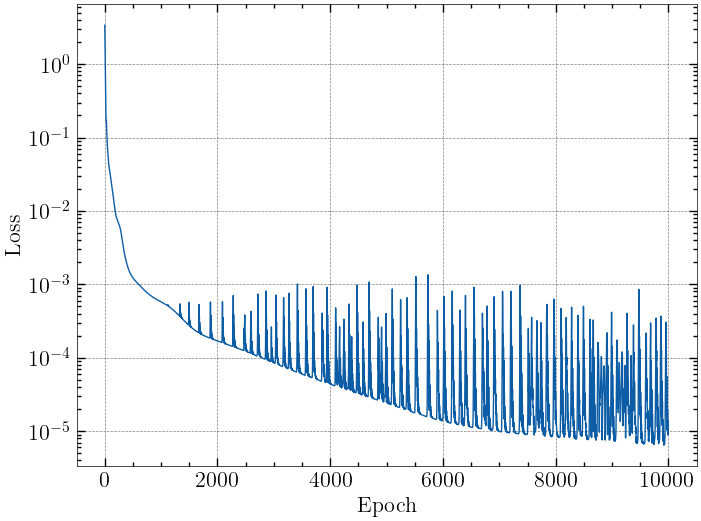

In [19]:
ode_system = Net_V2(input_dim=1, output_dim=2, n_units=5, loss2=physics_loss, epochs=10000, lr=1e-2, loss2_weight=1).to(DEVICE)
losses = ode_system.fit(t0, x0, y0)

plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:
# Make prediction.
t = np.linspace(0, 12, 500)
x_pred, y_pred = ode_system.predict(t)

In [21]:
# Save model
torch.save(ode_system.state_dict(), "ode_system.pth")

### Solving numerically, in order to compare the results.

In [22]:
def odes(t, y):
    y1, y2 = y
    dy1dt = y1 - y1*y2
    dy2dt = y1*y2 - y2
    return [dy1dt, dy2dt]

initial_conditions = [1.5, 1.0]

t_lims = (0, 12)

solution = solve_ivp(odes, t_lims, initial_conditions, t_eval=np.linspace(0, 12, 80))

t_num = solution.t
x_num = solution.y[0]
y_num = solution.y[1]

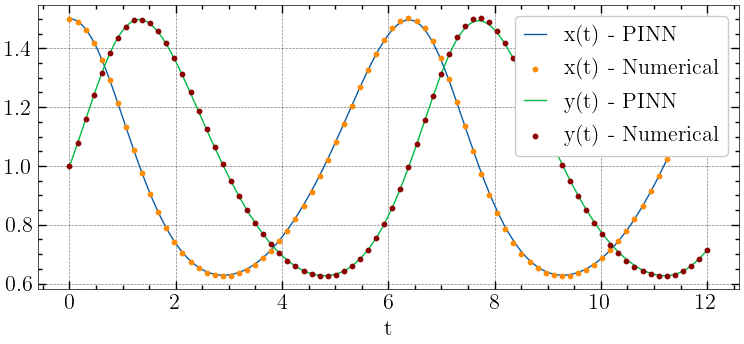

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

ax.plot(t, x_pred, label="x(t) - PINN", linewidth=1)
ax.scatter(t_num, x_num, label="x(t) - Numerical", color="darkorange", s=10, zorder=10)
ax.plot(t, y_pred, label="y(t) - PINN", linewidth=1)
ax.scatter(t_num, y_num, label="y(t) - Numerical", color="darkred", s=10, zorder=10)
legend = ax.legend(loc="best", handlelength=1)
legend.set_zorder(20)
ax.set_xlabel("t")

plt.show()

## Solving PDEs using PINNs.

A more advanced example would assume the PDE,

$$\frac{\partial u}{\partial x}=2\frac{\partial u}{\partial t}+u,$$

that satisfies the initial condition,

$$u(x,0)={6e}^{-3x},$$

where $x\in [0,2]$ and $t\in [0,1]$.

This PDE can also be represented by the function,

$$f(x,t,u)\equiv\frac{\partial u}{\partial x}-2\frac{\partial u}{\partial t}-u=0$$

The analytic solution to this PDE takes the form,

$$u(x, t)={6e}^{-3x-2t}$$

This part is based on: https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb

The following code is a functionalised version.

In [24]:
# Analytical solution
def u(x, t):
    return 6*np.exp(-3*x-2*t)

# f(x, t, u) = 0
def f(x, t, model: torch.nn.Module):
    u = model(x, t)
    u_x = grad(u, x)[0]
    u_t = grad(u, t)[0]
    pde = u_x - 2*u_t - u
    return pde

In [25]:
# Create a Net_V3 model that calculates u(x, t).

class Net_V3(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 n_units=100,
                 epochs=1000,
                 loss=nn.MSELoss(),
                 lr=1e-3,
                 loss2=None,
                 loss2_weight=0.1,
    ) -> None:
        # Inherit from superclass nn.Module
        super().__init__()
        
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.LogSigmoid(), # Can use Sigmoid or Tanh as well, but since the BCs behave exponentially, LogSigmoid leads to drastically smaller errors.
            nn.Linear(self.n_units, self.n_units),
            nn.LogSigmoid(),
            nn.Linear(self.n_units, self.n_units),
            nn.LogSigmoid(),
            nn.Linear(self.n_units, self.n_units),
            nn.LogSigmoid(),
            nn.Linear(self.n_units, self.n_units),
            nn.LogSigmoid()
        )
        self.out = nn.Linear(self.n_units, output_dim)
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], axis=1)
        return self.out(self.layers(inputs))
    
    def fit(self, X, T, u):
        Xt = np_to_th(X)
        Tt = np_to_th(T)
        ut = np_to_th(u)
        
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in tqdm(range(self.epochs)):
            optimizer.zero_grad()
            outputs = self.forward(Xt, Tt)
            loss = self.loss(outputs, ut) 
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if ep % int(self.epochs/10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
            
        return losses
    
    def predict(self, X, T):
        self.eval()
        out = self.forward(np_to_th(X), np_to_th(T))
        return out.detach().cpu().numpy()

In [26]:
# Data from Boundary Conditions
x_bc = np.linspace(0, 2, 500)
t_bc = np.zeros_like(x_bc)
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [27]:
def physics_loss(model: torch.nn.Module, loss=nn.MSELoss()):
    t_col = torch.linspace(0, 1, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    x_col = torch.linspace(0, 2, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    zeros = torch.zeros_like(t_col).float().view(-1,1).requires_grad_(False).to(DEVICE)
    pde = f(x_col, t_col, model)
    
    return loss(pde, zeros)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 0/20000, loss: 3.64
Epoch 2000/20000, loss: 2.19
Epoch 4000/20000, loss: 0.43
Epoch 6000/20000, loss: 0.02
Epoch 8000/20000, loss: 0.01
Epoch 10000/20000, loss: 0.01
Epoch 12000/20000, loss: 0.00
Epoch 14000/20000, loss: 0.00
Epoch 16000/20000, loss: 0.00
Epoch 18000/20000, loss: 0.00


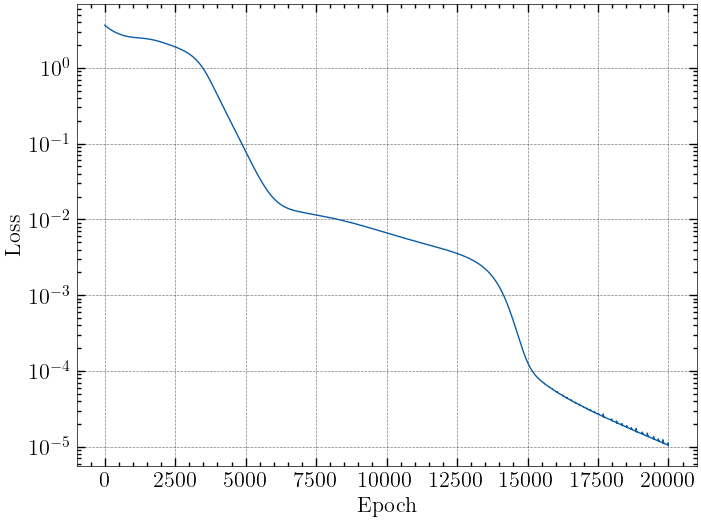

In [28]:
u_nn = Net_V3(input_dim=2, output_dim=1, n_units=5, loss2=physics_loss, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)
losses = u_nn.fit(x_bc, t_bc, u_bc)

plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
# Make prediction to compare to analytical solution (pay close attention to the reshaping!!!).
x = np.linspace(0, 2, 1000)
t = np.linspace(0, 1, 1000)
X, T = np.meshgrid(x, t)
x = np.ravel(X).reshape(-1,1)
t = np.ravel(T).reshape(-1,1)
preds = u_nn.predict(x, t).reshape(X.shape) # prediction 
analytical = u(X, T) # analytical

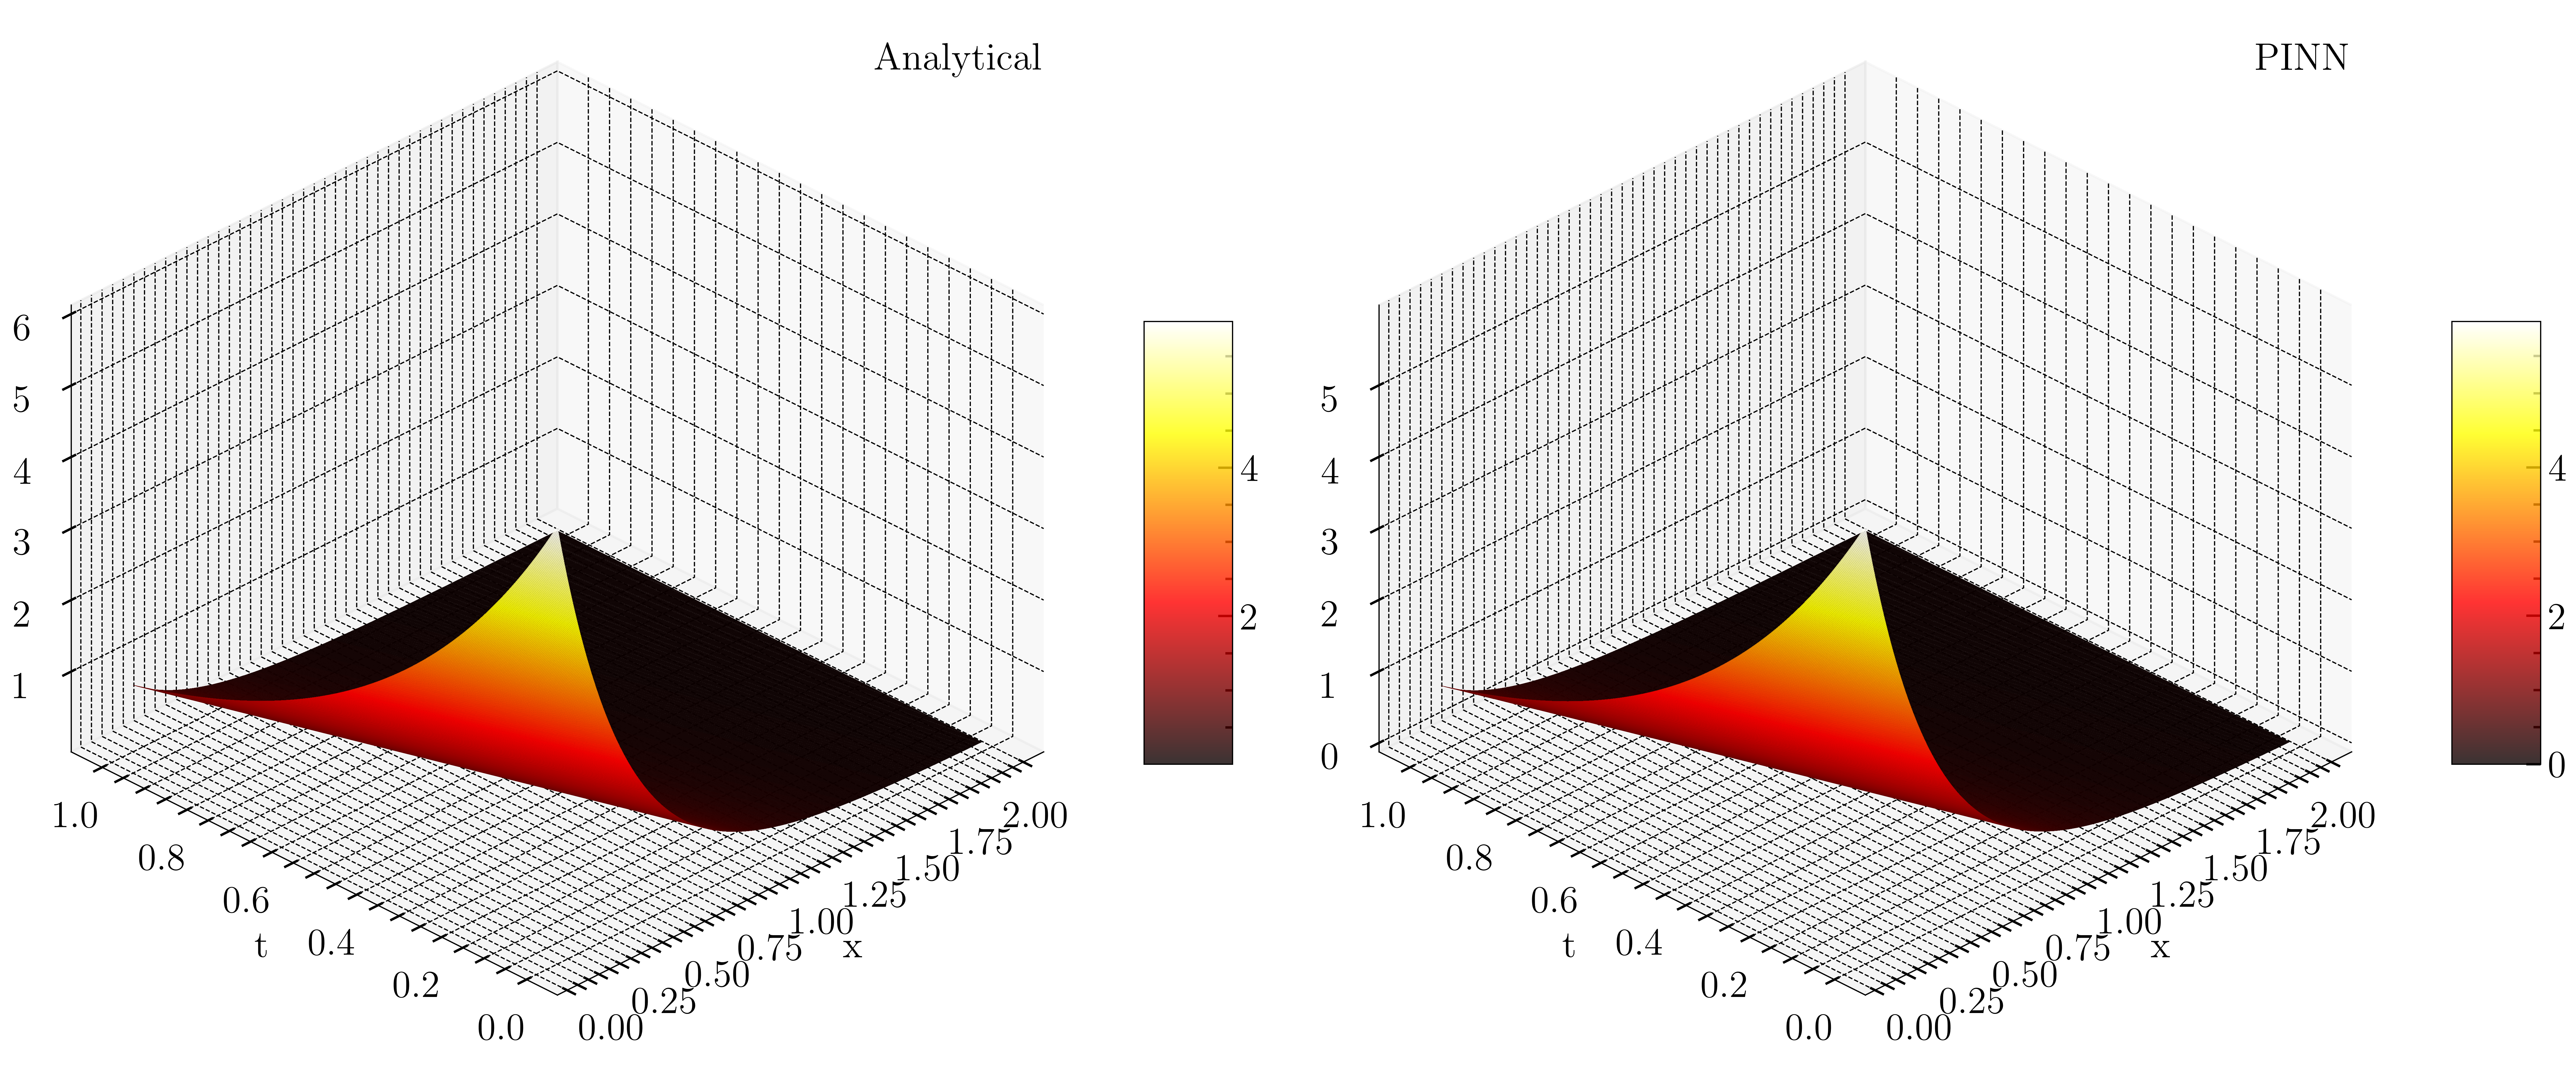

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": "3d"}, tight_layout=True, dpi=600)

ax = axs[0]
surf = ax.plot_surface(X, T, analytical, cmap="hot", rstride=2, cstride=1, alpha=0.8, linewidth=0.0, antialiased=False)
ax.set_xlabel("x") ; ax.set_ylabel("t")
fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c="black", marker = "")
ax.legend([fake2Dline], ["Analytical"], numpoints = 1, frameon=False)
fig.colorbar(surf, shrink=0.35, aspect=5)
ax.set_proj_type('ortho')
ax.view_init(30, 225)

ax = axs[1]
surf = ax.plot_surface(X, T, preds, cmap="hot", rstride=2, cstride=1, alpha=0.8, linewidth=0.0, antialiased=False) 
ax.set_xlabel("x") ; ax.set_ylabel("t")
fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c="black", marker = "")
ax.legend([fake2Dline], ["PINN"], numpoints = 1, frameon=False)
fig.colorbar(surf, shrink=0.35, aspect=5)
ax.set_proj_type('ortho')
ax.view_init(30, 225)

plt.savefig("PINN Bounary Condition PDE.pdf")
plt.savefig("PINN Bounary Condition PDE.png")
plt.show()

In [31]:
# Save model
torch.save(u_nn.state_dict(), "model_uxt.pth")

## Further Reading

Solving ODEs and PDEs using PINNs with the `neurodiffeq` library:

* README link: https://github.com/NeuroDiffGym/neurodiffeq/blob/master/README.md

* YouTube video walkthrough: https://www.youtube.com/watch?v=VDLwyFD-sXQ&feature=youtu.be

* NeuroDiffGym: https://github.com/NeuroDiffGym

* Toy examples from NeuroDiffGym: https://github.com/NeuroDiffGym/neurodiffeq-playground/blob/main/Examples.ipynb

* Handling complex IVP and BVP conditions with `neurodiffeq_conditions`: https://github.com/NeuroDiffGym/neurodiffeq-conditions/blob/main/README.md

Solutions to 3D problems (this notebook covers 1D and 2D problems):

* Vibrating circular membrane: https://github.com/NeuroDiffGym/neurodiffeq/blob/master/experiments/drum.ipynb

* 2D heat equation: https://github.com/NeuroDiffGym/neurodiffeq/blob/master/experiments/temporal-2d-test.ipynb

* More examples: https://github.com/NeuroDiffGym/neurodiffeq/tree/master/experiments

_The temporal module contains solvers for $n$ dimensionsional systems of PDEs that depend on 2 spatial coordinates and solvers for 3D singular PDEs that depend on 2 spatial and 1 time coordinate. I couldn't find a module that solves systems of the latter type. There either is a method hidden somewhere or it will be implemented in the future. A generalization of the previous examples should, however, render it possible to solve such problems. For example, one could attempt to solve the equations of hydrodynamics (i.e. 2D non-linear convection) and compare the results to the corresponding numerical solutions._

_Link for temporal module: https://github.com/NeuroDiffGym/neurodiffeq/blob/master/neurodiffeq/temporal.py_